# Plot trends at the ARM NSA site

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load ARM data

In [2]:
arm_path = '/glade/work/jonahshaw/obs/ARM/NSA/'

### The CDF files can be concatenated and work well.

In [3]:
atmos_files = glob.glob('%s/ATMOS/*.cdf' % arm_path)
atmos_files

['/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20040101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20030101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20070101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20020101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20050101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20060101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20090101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20100101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20080101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20010101.000000.custom.cdf']

#### .nc files are bad

In [4]:
atmos_files_nc = glob.glob('%s/ATMOS/*.nc' % arm_path)
atmos_files_nc

['/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20140101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20130101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20170101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20180101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20150101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20160101.003000.custom.nc']

#### Who did this stupid shit?

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [31]:
test_nc = xr.open_dataset(atmos_files_nc[0])

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

#### They also changed their variable naming convention. What is this?? Who does this?

#### I figured out that there is a variable called 'time_frac' with weird units that is preventing xarray from decoding correctly. If I just remove this variable everything is fine.

In [5]:
# bad_files = glob.glob('%s/ATMOS/old/*.nc' % arm_path)

In [110]:
# out_path = '%s/ATMOS/' % arm_path

# for f in bad_files:
#     file_head = f.split('/')[-1]
    
#     temp_file = xr.open_dataset(f,decode_times=False)
    
#     new_file = temp_file.drop(['time_frac','base_time']) # remove the bad variable    
#     new_file.to_netcdf('%s/%s' % (out_path,file_head)) # write to the processed directory
    
#     # close both files to save memory
#     temp_file.close()
#     new_file.close()

#### Testing the fix

In [6]:
new_files = glob.glob('%s/ATMOS/*.*' % (arm_path))

In [7]:
new_files.sort()
new_files

['/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20010101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20020101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20030101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20040101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20050101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20060101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20070101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20080101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20090101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20100101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20130101.003000.custom.nc',
 '/glade/work/jonahsha

In [8]:
all_ds = []
for i in new_files:
    all_ds.append(xr.open_dataset(i))

In [28]:
upsampled = []

for i in all_ds:
    
    try:
        i = i.rename({'temperature_sfc':'T_sfc'}) # handle two variable names (poorly?)
    except:
        pass
    t_monthly = i['T_sfc'].resample(time='1m',skipna=True,loffset='-15D').mean('time')
    upsampled.append(t_monthly)
    

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, a

In [25]:
all_t = xr.merge(upsampled)

### Missing 2011-2012

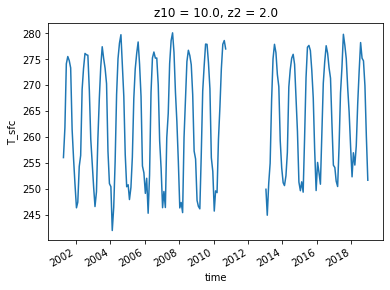

In [26]:
all_t['T_sfc'].plot()

In [40]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def plot_trends2(ds,title,units='K'):
    '''
    Create trend plot for preaveraged data.
    
    '''
    
#     var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
#     spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    
    fig,axes = plt.subplots(3,1,figsize=(8,10))

    lines=[]
    mon_groups = ds.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
        mon_norm = mon - mon.mean() # normalize to the average

        try:
            out = regress_1d(mon['time.year'],mon)
        except:
            print(mon)
            return
        line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
        label = '%s: %.2f %s /yr' % (mon_dict[str(ind)],out.coef_,units)


        mon_norm.plot(label=label,ax=axes[0],color=color)
        out = mon.plot(label=label,ax=axes[1],color=color)

        axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
        axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)

        lines.append(out)

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)

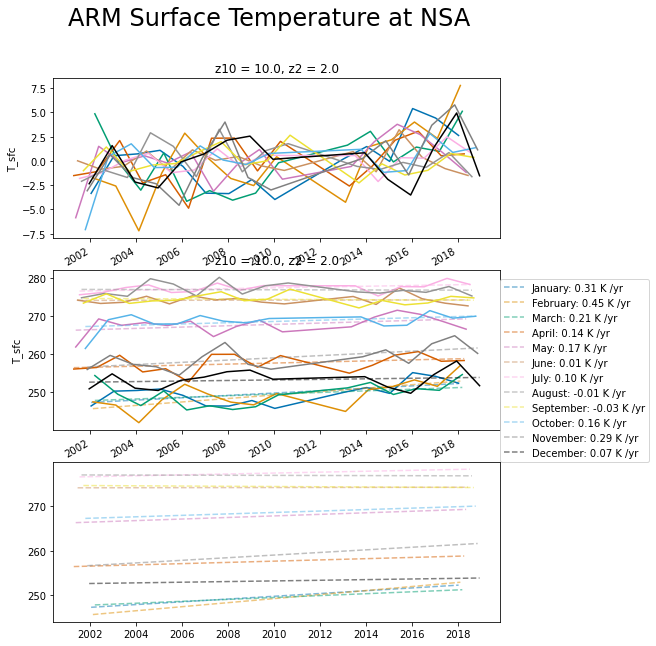

In [41]:
plot_trends2(all_t['T_sfc'].dropna('time'),title='ARM Surface Temperature at NSA',units='K')

In [116]:
newtime1 = all_ds[1]['T_sfc'].groupby('time.month').mean('time')
newtime2 = all_ds[2]['T_sfc'].groupby('time.month').mean('time')

In [9]:
test_sfc = all_ds[0]['T_sfc']

In [28]:
rsamp = test_sfc.resample(time='1m',skipna=True,loffset='-15D') # adjust by 15 days (arbitrary)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


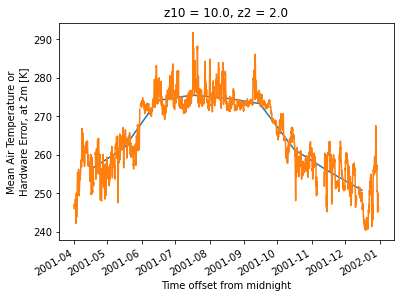

In [29]:
rsamp.mean('time').plot()

test_sfc.plot()

### There is a 1-month offset between these methods. I want to shift the resample backward by a month.

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


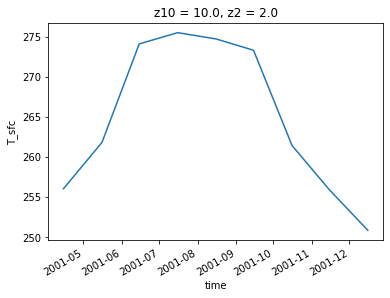

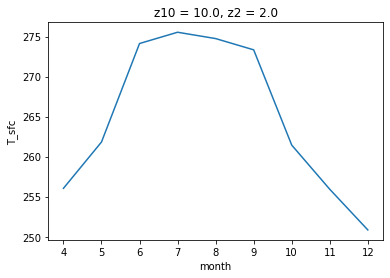

In [30]:
rsamp.mean('time').plot()

plt.figure()
test_sfc.groupby('time.month').mean('time').plot()

In [31]:
rsamp.mean('time')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'T_sfc' (time: 12)>
array([      nan,       nan,       nan, 256.03958, 261.82324, 274.12497,
       275.53256, 274.74097, 273.33478, 261.43784, 255.9208 , 250.8456 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-16 2001-02-13 ... 2001-12-16
    z10      float32 10.0
    z2       float32 2.0

In [100]:
xr.merge(all_ds[-2:])

MergeError: conflicting values for variable 'base_time' on objects to be combined. You can skip this check by specifying compat='override'.

In [103]:
new1 = all_ds[-1]

In [104]:
new2 = all_ds[-2]

In [105]:
xr.merge([new1,new2])

MergeError: conflicting values for variable 'base_time' on objects to be combined. You can skip this check by specifying compat='override'.

In [106]:
xr.merge([new1.drop('base_time'),new2.drop('base_time')])

<xarray.Dataset>
Dimensions:                    (bound: 2, height: 512, pressure: 37, time: 17496)
Coordinates:
  * time                       (time) datetime64[ns] 2017-01-01T00:30:00 ... ...
  * pressure                   (pressure) float32 1000.0 975.0 ... 125.0 100.0
  * height                     (height) float32 15.0 60.0 ... 22965.0 23010.0
Dimensions without coordinates: bound
Data variables:
    time_offset                (time) datetime64[ns] 2017-01-01T00:30:00 ... ...
    time_bounds                (time, bound) datetime64[ns] 2017-01-01 ... 20...
    pressure_bounds            (pressure, bound) float32 987.5 1012.5 ... 112.5
    height_bounds              (height, bound) float32 0.0 37.5 ... 23032.5
    height_10m                 float32 10.0
    height_2m                  float32 2.0
    u_wind_sfc                 (time) float32 -0.24457985 ... -0.35891572
    v_wind_sfc                 (time) float32 3.551832 3.8586159 ... 2.788552
    relative_humidity_sfc      (time) float32 83.08833 82.81965 ... 73.98902
    pressure_sfc               (time) float32 1016.9916 1016.6708 ... 1004.0885
    precip_rate_sfc            (time) float32 0.0026666669 0.0 ... 0.0013114754
    sensible_heat_flux_baebbr  (time) float32 nan nan nan nan ... nan nan nan
    latent_heat_flux_baebbr    (time) float32 nan nan nan nan ... nan nan nan
    temperature_sfc            (time) float32 259.50632 260.4556 ... 241.5387
    sensible_heat_flux_qcecor  (time) float32 -0.7165 0.59865 ... nan nan
    latent_heat_flux_qcecor    (time) float32 nan 1.5485001 ... nan nan
    temperature_p              (time, pressure) float32 nan nan nan ... nan nan
    temperature_h              (time, height) float32 nan nan nan ... nan nan
    dewpoint_p                 (time, pressure) float32 nan nan nan ... nan nan
    dewpoint_h                 (time, height) float32 nan nan nan ... nan nan
    u_wind_p                   (time, pressure) float32 nan nan nan ... nan nan
    u_wind_h                   (time, height) float32 nan nan nan ... nan nan
    v_wind_p                   (time, pressure) float32 nan nan nan ... nan nan
    v_wind_h                   (time, height) float32 nan nan nan ... nan nan
    relative_humidity_p        (time, pressure) float32 nan nan nan ... nan nan
    relative_humidity_h        (time, height) float32 nan nan nan ... nan nan
    u_wind_nwp_p               (time, pressure) float32 nan nan nan ... nan nan
    v_wind_nwp_p               (time, pressure) float32 nan nan nan ... nan nan
    omega_nwp_p                (time, pressure) float32 nan nan nan ... nan nan
    temperature_nwp_p          (time, pressure) float32 nan nan nan ... nan nan
    relative_humidity_nwp_p    (time, pressure) float32 nan nan nan ... nan nan
    lat                        float64 71.32
    lon                        float64 -156.6
    alt                        float64 8.0

In [108]:
new1

<xarray.Dataset>
Dimensions:                    (bound: 2, height: 512, pressure: 37, time: 8736)
Coordinates:
  * time                       (time) datetime64[ns] 2018-01-01T00:30:00 ... ...
  * pressure                   (pressure) float32 1000.0 975.0 ... 125.0 100.0
  * height                     (height) float32 15.0 60.0 ... 22965.0 23010.0
Dimensions without coordinates: bound
Data variables:
    base_time                  datetime64[ns] 2018-01-01
    time_offset                (time) datetime64[ns] 2018-01-01T00:30:00 ... ...
    time_bounds                (time, bound) datetime64[ns] 2018-01-01 ... 20...
    pressure_bounds            (pressure, bound) float32 987.5 1012.5 ... 112.5
    height_bounds              (height, bound) float32 0.0 37.5 ... 23032.5
    height_10m                 float32 10.0
    height_2m                  float32 2.0
    u_wind_sfc                 (time) float32 -5.672872 ... -0.35891572
    v_wind_sfc                 (time) float32 -2.484643 -1.4918498 ... 2.788552
    relative_humidity_sfc      (time) float32 78.93632 80.00639 ... 73.98902
    pressure_sfc               (time) float32 1024.455 1024.0537 ... 1004.0885
    precip_rate_sfc            (time) float32 0.01983333 ... 0.0013114754
    sensible_heat_flux_baebbr  (time) float32 nan nan nan nan ... nan nan nan
    latent_heat_flux_baebbr    (time) float32 nan nan nan nan ... nan nan nan
    temperature_sfc            (time) float32 253.93182 254.29936 ... 241.5387
    sensible_heat_flux_qcecor  (time) float32 -9.3885 -10.4165 ... nan nan
    latent_heat_flux_qcecor    (time) float32 nan nan nan nan ... nan nan nan
    temperature_p              (time, pressure) float32 ...
    temperature_h              (time, height) float32 ...
    dewpoint_p                 (time, pressure) float32 ...
    dewpoint_h                 (time, height) float32 ...
    u_wind_p                   (time, pressure) float32 ...
    u_wind_h                   (time, height) float32 ...
    v_wind_p                   (time, pressure) float32 ...
    v_wind_h                   (time, height) float32 ...
    relative_humidity_p        (time, pressure) float32 ...
    relative_humidity_h        (time, height) float32 ...
    u_wind_nwp_p               (time, pressure) float32 ...
    v_wind_nwp_p               (time, pressure) float32 ...
    omega_nwp_p                (time, pressure) float32 ...
    temperature_nwp_p          (time, pressure) float32 ...
    relative_humidity_nwp_p    (time, pressure) float32 ...
    lat                        float64 71.32
    lon                        float64 -156.6
    alt                        float64 8.0
Attributes:
    Conventions:           ARM-1.2
    command_line:          idl -R -n adi_armbeatm -s nsa -f C1 -b 20130101 -e...
    title:                 ARM Best Estimate (ARMBE) Product, atmospheric pro...
    description:           ARM Best Estimate hourly averaged qc controlled pr...
    location_description:  North Slope of Alaska (NSA), Barrow, Alaska
    platform_id:           armbeatm
    averaging_interval:    60 min
    references:            http://dx.doi.org/10.5439/1333748
    datastream:            nsaarmbeatmC1.c1
    site_id:               nsa
    facility_id:           C1
    data_level:            c1
    dod_version:           armbeatm-c1-1.7
    process_version:       $
    input_datastreams:     nsa30ecorE10.b1 : 13.4 : 20180101.000000-20181231....
    doi:                   10.5439/1333748
    history:               created by user tang on machine lead at 2019-01-07...

In [107]:
new1.drop(['base_time','time_offset'])

<xarray.Dataset>
Dimensions:                    (bound: 2, height: 512, pressure: 37, time: 8736)
Coordinates:
  * time                       (time) datetime64[ns] 2018-01-01T00:30:00 ... ...
  * pressure                   (pressure) float32 1000.0 975.0 ... 125.0 100.0
  * height                     (height) float32 15.0 60.0 ... 22965.0 23010.0
Dimensions without coordinates: bound
Data variables:
    time_bounds                (time, bound) datetime64[ns] 2018-01-01 ... 20...
    pressure_bounds            (pressure, bound) float32 987.5 1012.5 ... 112.5
    height_bounds              (height, bound) float32 0.0 37.5 ... 23032.5
    height_10m                 float32 10.0
    height_2m                  float32 2.0
    u_wind_sfc                 (time) float32 -5.672872 ... -0.35891572
    v_wind_sfc                 (time) float32 -2.484643 -1.4918498 ... 2.788552
    relative_humidity_sfc      (time) float32 78.93632 80.00639 ... 73.98902
    pressure_sfc               (time) float32 1024.455 1024.0537 ... 1004.0885
    precip_rate_sfc            (time) float32 0.01983333 ... 0.0013114754
    sensible_heat_flux_baebbr  (time) float32 nan nan nan nan ... nan nan nan
    latent_heat_flux_baebbr    (time) float32 nan nan nan nan ... nan nan nan
    temperature_sfc            (time) float32 253.93182 254.29936 ... 241.5387
    sensible_heat_flux_qcecor  (time) float32 -9.3885 -10.4165 ... nan nan
    latent_heat_flux_qcecor    (time) float32 nan nan nan nan ... nan nan nan
    temperature_p              (time, pressure) float32 ...
    temperature_h              (time, height) float32 ...
    dewpoint_p                 (time, pressure) float32 ...
    dewpoint_h                 (time, height) float32 ...
    u_wind_p                   (time, pressure) float32 ...
    u_wind_h                   (time, height) float32 ...
    v_wind_p                   (time, pressure) float32 ...
    v_wind_h                   (time, height) float32 ...
    relative_humidity_p        (time, pressure) float32 ...
    relative_humidity_h        (time, height) float32 ...
    u_wind_nwp_p               (time, pressure) float32 ...
    v_wind_nwp_p               (time, pressure) float32 ...
    omega_nwp_p                (time, pressure) float32 ...
    temperature_nwp_p          (time, pressure) float32 ...
    relative_humidity_nwp_p    (time, pressure) float32 ...
    lat                        float64 71.32
    lon                        float64 -156.6
    alt                        float64 8.0
Attributes:
    Conventions:           ARM-1.2
    command_line:          idl -R -n adi_armbeatm -s nsa -f C1 -b 20130101 -e...
    title:                 ARM Best Estimate (ARMBE) Product, atmospheric pro...
    description:           ARM Best Estimate hourly averaged qc controlled pr...
    location_description:  North Slope of Alaska (NSA), Barrow, Alaska
    platform_id:           armbeatm
    averaging_interval:    60 min
    references:            http://dx.doi.org/10.5439/1333748
    datastream:            nsaarmbeatmC1.c1
    site_id:               nsa
    facility_id:           C1
    data_level:            c1
    dod_version:           armbeatm-c1-1.7
    process_version:       $
    input_datastreams:     nsa30ecorE10.b1 : 13.4 : 20180101.000000-20181231....
    doi:                   10.5439/1333748
    history:               created by user tang on machine lead at 2019-01-07...

In [92]:
xr.open_dataset(new_files[-7])

<xarray.Dataset>
Dimensions:      (p: 37, range: 2, time: 8760, z: 512)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-01T00:30:00 ... 2010-12-31T23:...
  * p            (p) float32 1000.0 975.0 950.0 925.0 ... 150.0 125.0 100.0
  * z            (z) float32 15.0 60.0 105.0 150.0 ... 22920.0 22965.0 23010.0
    z10          float32 ...
    z2           float32 ...
Dimensions without coordinates: range
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    time_bounds  (time, range) datetime64[ns] ...
    time_frac    (time) datetime64[ns] ...
    p_bounds     (p, range) float64 ...
    z_bounds     (z, range) float64 ...
    u_sfc        (time) float32 ...
    v_sfc        (time) float32 ...
    T_sfc        (time) float32 ...
    rh_sfc       (time) float32 ...
    p_sfc        (time) float32 ...
    prec_sfc     (time) float32 ...
    T_p          (time, p) float32 ...
    T_z          (time, z) float32 ...
    Td_p         (time, p) float32 ...
    Td_z         (time, z) float32 ...
    rh_p         (time, p) float32 ...
    rh_z         (time, z) float32 ...
    u_p          (time, p) float32 ...
    u_z          (time, z) float32 ...
    v_p          (time, p) float32 ...
    v_z          (time, z) float32 ...
    lat          float32 ...
    lon          float32 ...
    alt          float32 ...
Attributes:
    Conventions:             CF-1.6
    title:                   ARM Best Estimate (ARMBE) Product, atmospheric p...
    description:             ARM Best Estimate hourly averaged qc controlled ...
    project:                 Atmospheric Radiation Measurements (ARM) Program...
    location:                NSA, C1; lon = 156.6 W, lat = 71.3 N, alt = 7.6 ...
    averaging_interval:      60 min. reported at the center of the interval
    references:              http://science.arm.gov/wg/cpm/scm/best_estimate....
    institution:             Lawrence Livermore National Laboratory, CA, USA
    software:                IDL program, R.B.McCoy, LLNL, renata@llnl.gov
    source:                  ARM VAPs: MET, sounding
    source_met:              nsametC1.b1.2010*.cdf
    source_sonde:            nsasondewnpnC1.b1.2010*.cdf
    site_id:                 nsa
    facility_id:             C1
    platform_id:             armbeatm
    datastream:              nsaarmbeatmC1.c1
    location_description:    North Slope of Alaska (NSA), Barrow, Alaska
    data_level:              c1
    dod_version:             armbeatm-c1-1.4
    process_version:         armbeatm v1.4
    command_line:            armbeatm_correct_soundings_v1.4
    input_datastreams:       nsaarmbeatmC1.c1:1.3:20100101; nsasondewnpnC1.b1...
    postprocessing_date:     Tue Feb  4 01:40:10 2014 UTC
    postprocessing_commnd:   armbeatm_correct_soundings_v1.4
    postprocessing_svn_tag:  9650
    doi:                     10.5439/1111572
    doi_url:                 http://dx.doi.org/10.5439/1111572
    suggested_citation:      see http://www.arm.gov/data/armbe
    history:                 created by user mccoy20 on machine dream.llnl.go...

In [83]:
all_data = xr.open_mfdataset(new_files)

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

The data is there...

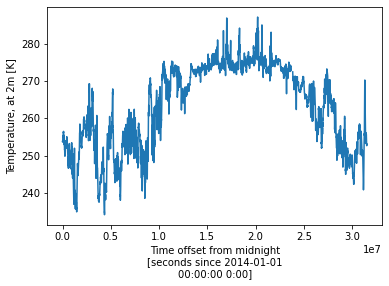

In [40]:
test_nc['temperature_sfc'].plot()

In [44]:
test_nc.time

<xarray.DataArray 'time' (time: 8760)>
array([1.80000e+03, 5.40000e+03, 9.00000e+03, ..., 3.15270e+07, 3.15306e+07,
       3.15342e+07])
Coordinates:
  * time     (time) float64 1.8e+03 5.4e+03 9e+03 ... 3.153e+07 3.153e+07
Attributes:
    long_name:      Time offset from midnight
    units:          seconds since 2014-01-01 00:00:00 0:00
    calendar:       gregorian
    axis:           T
    bounds:         time_bounds
    standard_name:  time

__What I get about the time coordinate from an ncdump command__

	int base_time ;
		base_time:string = "2013-01-01 00:00:00 0:00" ;
		base_time:long_name = "Base time in Epoch" ;
		base_time:units = "seconds since 1970-1-1 0:00:00 0:00" ;
		base_time:ancillary_variables = "time_offset" ;
	double time_offset(time) ;
		time_offset:long_name = "Time offset from base_time" ;
		time_offset:units = "seconds since 2013-01-01 00:00:00 0:00" ;
		time_offset:ancillary_variables = "base_time" ;
		time_offset:bounds = "time_bounds" ;
		time_offset:calendar = "gregorian" ;
	double time(time) ;
		time:long_name = "Time offset from midnight" ;
		time:units = "seconds since 2013-01-01 00:00:00 0:00" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;
		time:bounds = "time_bounds" ;
		time:standard_name = "time" ;
	double time_bounds(time, bound) ;
		time_bounds:long_name = "Time cell bounds" ;
		time_bounds:bound_offsets = -1800., 1800. ;
	float time_frac(time) ;
		time_frac:long_name = "Calendar day fraction of the year" ;
		time_frac:units = "days since last day of the previous year" ;
		time_frac:calendar = "gregorian" ;

The "time_frac" variable appears to be the culprit here.

In [47]:
test_nc.time

<xarray.DataArray 'time' (time: 8760)>
array([1.80000e+03, 5.40000e+03, 9.00000e+03, ..., 3.15270e+07, 3.15306e+07,
       3.15342e+07])
Coordinates:
  * time     (time) float64 1.8e+03 5.4e+03 9e+03 ... 3.153e+07 3.153e+07
Attributes:
    long_name:      Time offset from midnight
    units:          seconds since 2014-01-01 00:00:00 0:00
    calendar:       gregorian
    axis:           T
    bounds:         time_bounds
    standard_name:  time

In [54]:
new_time = test_nc['time_frac'].assign_attrs({'time':'days since 2013-12-31 00:00:00 0:00'})

In [56]:
new_time

<xarray.DataArray 'time_frac' (time: 8760)>
array([  1.020833,   1.0625  ,   1.104167, ..., 365.89584 , 365.9375  ,
       365.97916 ], dtype=float32)
Coordinates:
  * time     (time) float64 1.8e+03 5.4e+03 9e+03 ... 3.153e+07 3.153e+07
Attributes:
    long_name:  Calendar day fraction of the year
    units:      days since last day of the previous year
    calendar:   gregorian
    time:       days since 2013-12-31 00:00:00 0:00

In [61]:
test_nc['time_frac'] = new_time

In [62]:
test_nc.time_frac

<xarray.DataArray 'time_frac' (time: 8760)>
array([  1.020833,   1.0625  ,   1.104167, ..., 365.89584 , 365.9375  ,
       365.97916 ], dtype=float32)
Coordinates:
  * time     (time) float64 1.8e+03 5.4e+03 9e+03 ... 3.153e+07 3.153e+07
Attributes:
    long_name:  Calendar day fraction of the year
    units:      days since last day of the previous year
    calendar:   gregorian
    time:       days since 2013-12-31 00:00:00 0:00

In [66]:
no_frac = test_nc.drop('time_frac')

In [68]:
fixd = xr.decode_cf(no_frac)

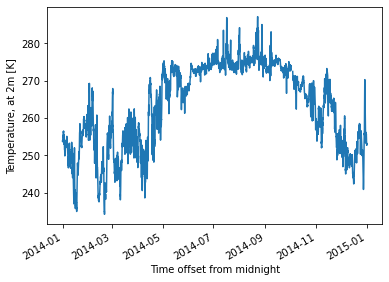

In [69]:
fixd['temperature_sfc'].plot()

In [60]:
test = xr.decode_cf(test_nc)

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [43]:
xr.decode_cf(test_nc)
# xr.decode_cf(test_nc['temperature_sfc'])

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [25]:
all_atmos = xr.open_mfdataset(atmos_files)

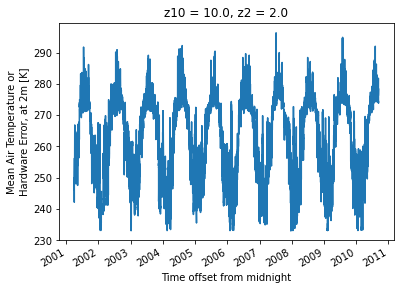

In [29]:
all_atmos['T_sfc'].plot()

In [19]:
test_arm = xr.open_dataset('%s/ATMOS/%s' % (arm_path,'nsaarmbeatmC1.c1.20010101.000000.custom.cdf'))

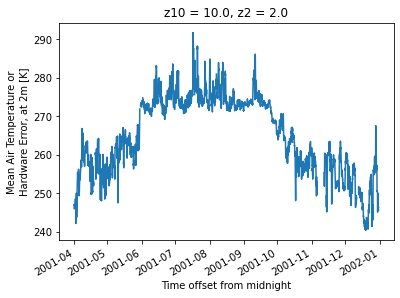

In [22]:
test_arm['T_sfc'].plot()

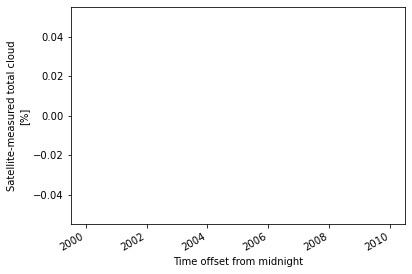

In [16]:
test_arm['cld_tot'].plot()

In [10]:
time_avg = test_arm['cld_tot'].groupby('time.month').mean('time')

In [11]:
time_avg

<xarray.DataArray 'cld_tot' (month: 12)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12